Text(0, 0.5, 'number of pixels')

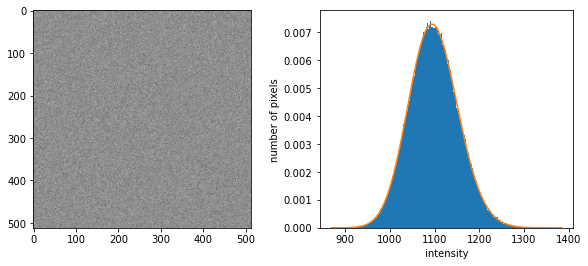

In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import lognorm, norm, binom
from matplotlib import pyplot as plt
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
from multiprocessing import Pool
from numba import jit, set_num_threads
from cmdstanpy import CmdStanModel

# setting number of cores for numba and multiprocessing (but not Stan)
num_cores = 4
set_num_threads(num_cores)

# sampling a background image with lognormally-distributed intensity
image_dims = (512, 512)
background_sigma = 0.05
background_mu = 7
rng = default_rng()
background = rng.lognormal(background_mu, background_sigma, image_dims)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(background, cmap = "binary")
_, bins, _ = axes[1].hist(background.flatten(), bins = "auto", density = True)
xvals = np.linspace(bins[0], bins[-1], 10000)

axes[1].plot(xvals, lognorm.pdf(xvals, s = background_sigma,
                                scale = np.exp(background_mu)))
axes[1].set_xlabel("intensity")
axes[1].set_ylabel("number of pixels")

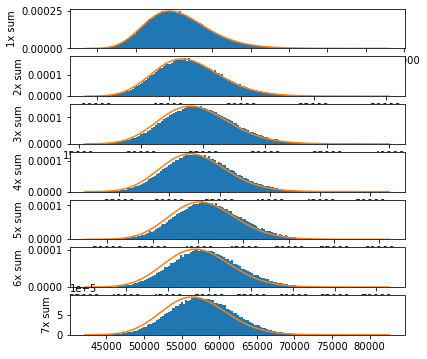

In [2]:
# basis for approx RA method, showing scaling sigma by 1 / sqrt(n)

mu = 9
sigma = 0.2

f, axes = plt.subplots(7, figsize = (6, 6))
for n in range(1, 8):
    test = np.sum(rng.lognormal(mu, sigma, (100000, n)), axis = 1)
    xvals = np.linspace(np.min(test), np.max(test), 10000)
    axes[n-1].hist(test, bins = "auto", density = True)
    axes[n-1].plot(xvals, lognorm.pdf(xvals, s = sigma / np.sqrt(n),
                                      scale = n * np.exp(mu)))
    axes[n-1].set_ylabel(str(n) + "x sum")

375


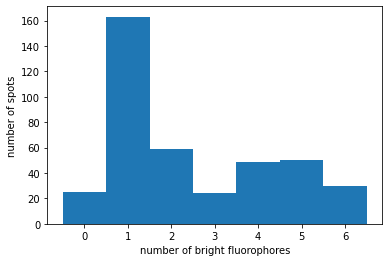

In [3]:
# sample binomially-distributed fluorophore distribution
num_spots = 400
spot_sigma = 1.5
monomer_sigma = 0.1
monomer_mu = 9
oligomeric_states = np.array([1,2,3,4,5,6])
oligomeric_probabilities = np.array([0.4,0.2,0,0.1,0,0.3])
fluorophore_bright_probability = 0.8

num_fluorophores = rng.choice(oligomeric_states, num_spots,
                              p = oligomeric_probabilities)
num_bright_fluorophores = rng.binomial(num_fluorophores,
                                       fluorophore_bright_probability)

yvals_lower = np.arange(image_dims[0])
yvals_upper = np.arange(image_dims[0]) + 1.0
xvals_lower = np.arange(image_dims[1])
xvals_upper = np.arange(image_dims[1]) + 1.0

plt.hist(num_bright_fluorophores,
         bins = np.arange(np.max(oligomeric_states) + 2) - 0.5)
plt.xlabel("number of bright fluorophores")
plt.ylabel("number of spots")

print(np.sum(num_bright_fluorophores != 0))

Text(0.5, 1.0, 'true spot histogram')

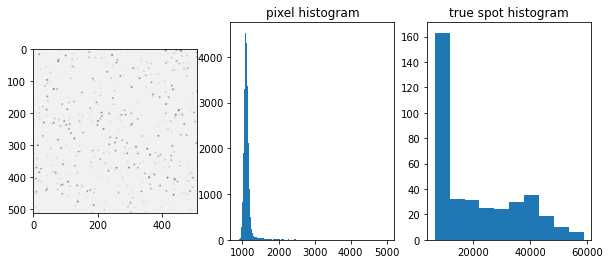

In [4]:
# MD
spot_images_md = np.zeros((num_spots, *image_dims))
intensities_md = rng.lognormal((monomer_mu +
                                np.log(num_bright_fluorophores
                                           [num_bright_fluorophores != 0])),
                               monomer_sigma)
spot_centers_md = np.empty((intensities_md.shape[0], 2))
for i, intensity in enumerate(intensities_md):
    spot_centers_md[i] = (rng.uniform(0.0, image_dims[0]),
                          rng.uniform(0.0, image_dims[1]))
    spot_images_md[i] = (intensity * (norm.cdf(yvals_upper,
                                               spot_centers_md[i, 0],
                                               spot_sigma) -
                                      norm.cdf(yvals_lower,
                                               spot_centers_md[i, 0],
                                               spot_sigma))[:, np.newaxis] *
                         (norm.cdf(xvals_upper, spot_centers_md[i, 1],
                                   spot_sigma) -
                          norm.cdf(xvals_lower, spot_centers_md[i, 1],
                                   spot_sigma))[np.newaxis, :])
image_md = np.sum(spot_images_md, axis = 0) + background

f, axes = plt.subplots(1, 3, figsize = (10, 4))
axes[0].imshow(image_md, cmap = "binary")
axes[1].hist(image_md.flatten(), bins = "auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_md, bins = "auto")
axes[2].set_title("true spot histogram")

Text(0.5, 1.0, 'true spot histogram')

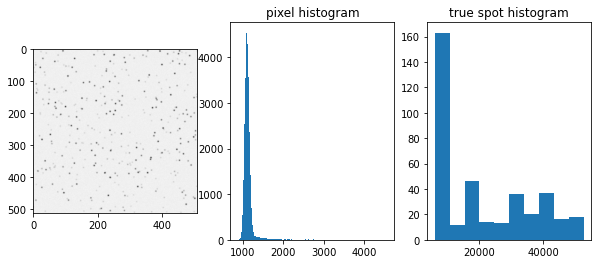

In [5]:
# RA
spot_images_ra = np.zeros((num_spots, *image_dims))
intensities_ra = np.zeros(num_spots)[num_bright_fluorophores != 0]
spot_centers_ra = np.empty((intensities_ra.shape[0], 2))
for i, num_bright in enumerate(num_bright_fluorophores[num_bright_fluorophores != 0]):
    spot_centers_ra[i] = (rng.uniform(0.0, image_dims[0]), rng.uniform(0.0, image_dims[1]))
    for j in range(num_bright):
        intensity = rng.lognormal(monomer_mu, monomer_sigma)
        intensities_ra[i] += intensity
        spot_images_ra[i] += (intensity * (norm.cdf(yvals_upper,
                                                    spot_centers_ra[i, 0],
                                                    spot_sigma) -
                                           norm.cdf(yvals_lower,
                                                    spot_centers_ra[i, 0],
                                                    spot_sigma))
                                               [:, np.newaxis] *
                              (norm.cdf(xvals_upper, spot_centers_ra[i, 1],
                                        spot_sigma) -
                               norm.cdf(xvals_lower, spot_centers_ra[i, 1],
                                        spot_sigma))[np.newaxis, :])
image_ra = np.sum(spot_images_ra, axis = 0) + background

f, axes = plt.subplots(1, 3, figsize = (10, 4))
axes[0].imshow(image_ra, cmap = "binary")
axes[1].hist(image_ra.flatten(), bins = "auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_ra, bins = "auto")
axes[2].set_title("true spot histogram")

Text(0.5, 1.0, 'true spot histogram')

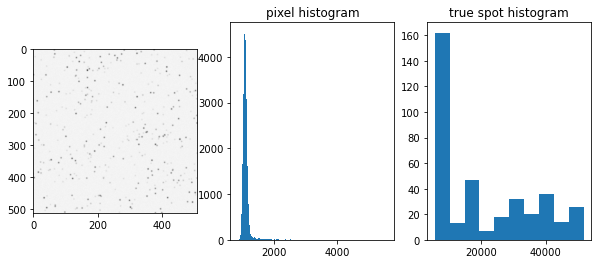

In [6]:
# approx RA, scaling sigma by 1 / sqrt(n)
spot_images_approx_ra = np.zeros((num_spots, *image_dims))
intensities_approx_ra = rng.lognormal((monomer_mu +
                                       np.log(num_bright_fluorophores
                                              [num_bright_fluorophores != 0])),
                                      (monomer_sigma /
                                       np.sqrt(num_bright_fluorophores
                                               [num_bright_fluorophores != 0])))
spot_centers_approx_ra = np.empty((intensities_approx_ra.shape[0], 2))
for i, intensity in enumerate(intensities_approx_ra):
    spot_centers_approx_ra[i] = (rng.uniform(0.0, image_dims[0]),
                                 rng.uniform(0.0, image_dims[1]))
    spot_images_approx_ra[i] = (intensity *
                                (norm.cdf(yvals_upper,
                                          spot_centers_approx_ra[i, 0],
                                          spot_sigma) -
                                 norm.cdf(yvals_lower,
                                          spot_centers_approx_ra[i, 0],
                                          spot_sigma))[:, np.newaxis] *
                                (norm.cdf(xvals_upper,
                                          spot_centers_approx_ra[i, 1],
                                          spot_sigma) -
                                 norm.cdf(xvals_lower,
                                          spot_centers_approx_ra[i, 1],
                                          spot_sigma))[np.newaxis, :])
image_approx_ra = np.sum(spot_images_approx_ra, axis = 0) + background

f, axes = plt.subplots(1, 3, figsize = (10, 4))
axes[0].imshow(image_approx_ra, cmap = "binary")
axes[1].hist(image_approx_ra.flatten(), bins = "auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_approx_ra, bins = "auto")
axes[2].set_title("true spot histogram")

In [7]:
thresholds = 10.0 ** np.linspace(2, 3.5, 20)
threshold_to_use = 150.0
sigma_guess = 1.6

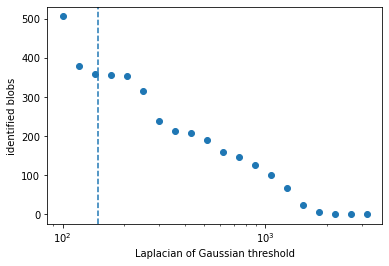

In [8]:
def blob_log_fixedargs(threshold):
    return blob_log(image_md, threshold = threshold,
                    min_sigma = 0.5 * sigma_guess,
                    max_sigma = 2.0 * sigma_guess, num_sigma = 40)
with Pool(num_cores) as pool:
    blobs_log_md = pool.map(blob_log_fixedargs, thresholds)

plt.scatter(thresholds, [len(blobs) for blobs in blobs_log_md])
plt.xlabel("Laplacian of Gaussian threshold")
plt.ylabel("identified blobs")
plt.xscale("log")
plt.axvline(threshold_to_use, ls = "dashed")
plt.show()

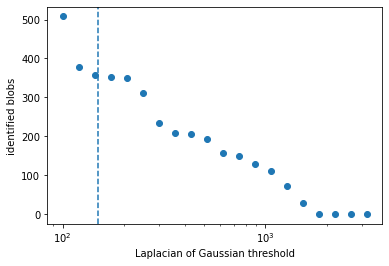

In [9]:
def blob_log_fixedargs(threshold):
    return blob_log(image_ra, threshold = threshold,
                    min_sigma = 0.5 * sigma_guess,
                    max_sigma = 2.0 * sigma_guess, num_sigma = 40)
with Pool(num_cores) as pool:
    blobs_log_ra = pool.map(blob_log_fixedargs, thresholds)

plt.scatter(thresholds, [len(blobs) for blobs in blobs_log_ra])
plt.xlabel("Laplacian of Gaussian threshold")
plt.ylabel("identified blobs")
plt.xscale("log")
plt.axvline(threshold_to_use, ls = "dashed")
plt.show()

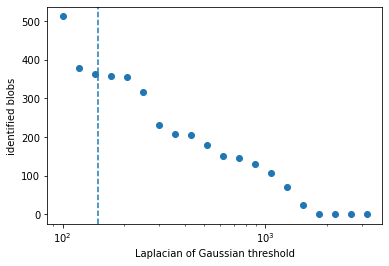

In [10]:
def blob_log_fixedargs(threshold):
    return blob_log(image_approx_ra, threshold = threshold,
                    min_sigma = 0.5 * sigma_guess,
                    max_sigma = 2.0 * sigma_guess, num_sigma = 40)
with Pool(num_cores) as pool:
    blobs_log_approx_ra = pool.map(blob_log_fixedargs, thresholds)

plt.scatter(thresholds, [len(blobs) for blobs in blobs_log_approx_ra])
plt.xlabel("Laplacian of Gaussian threshold")
plt.ylabel("identified blobs")
plt.xscale("log")
plt.axvline(threshold_to_use, ls = "dashed")
plt.show()

Text(0, 0.5, 'estimated intensity of closest spot')

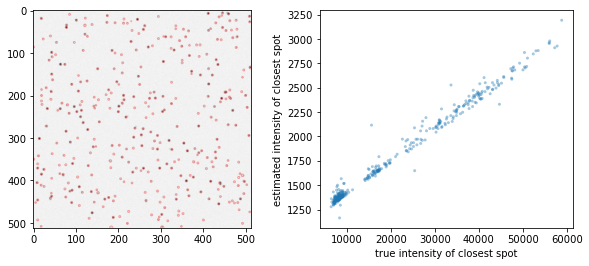

In [11]:
blobs_md = blob_log(image_md, threshold = threshold_to_use,
                    min_sigma = 0.5 * sigma_guess,
                    max_sigma = 2.0 * sigma_guess, num_sigma = 40)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(image_md, cmap = "binary")

blob_intensities_md = []
closest_intensities_md = []
for blob in blobs_md:
    y, x, r = blob
    blob_intensities_md.append(gaussian_filter(image_md, r)[int(y), int(x)])
    closest_intensities_md.append(intensities_md
                                  [np.argmin(np.square(y -
                                                       spot_centers_md[:, 0]) +
                                             np.square(x -
                                                       spot_centers_md[:, 1]))])
    c = plt.Circle((x, y), r * np.sqrt(2), color = "red", linewidth = 1,
                   fill = False, alpha = 0.3)
    axes[0].add_patch(c)
    
axes[1].scatter(closest_intensities_md, blob_intensities_md, alpha = 0.4,
                edgecolor = "none", marker = '.')
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

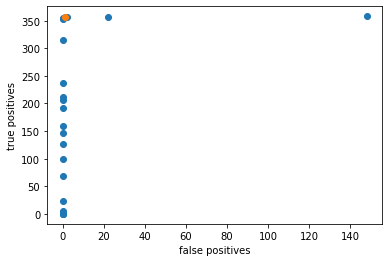

In [12]:
true_positives = []
false_positives = []
for blobs in blobs_log_md:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if np.min(np.square(y - spot_centers_md[:, 0]) +
                  np.square(x - spot_centers_md[:, 1])) < 2.0 * r:
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_md:
    y, x, r = blob
    if np.min(np.square(y - spot_centers_md[:, 0]) +
              np.square(x - spot_centers_md[:, 1])) < 2.0 * r:
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

Text(0, 0.5, 'estimated intensity of closest spot')

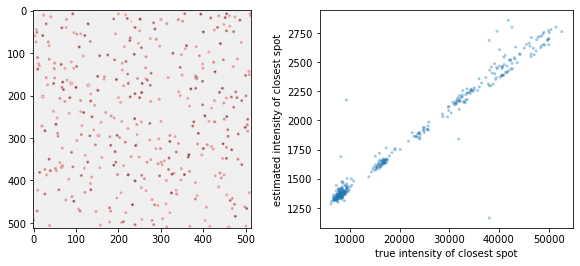

In [13]:
blobs_ra = blob_log(image_ra, threshold = threshold_to_use,
                    min_sigma = 0.5 * sigma_guess,
                    max_sigma = 2.0 * sigma_guess, num_sigma = 40)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(image_ra, cmap = "binary")

blob_intensities_ra = []
closest_intensities_ra = []
for blob in blobs_ra:
    y, x, r = blob
    blob_intensities_ra.append(gaussian_filter(image_ra, r)[int(y), int(x)])
    closest_intensities_ra.append(intensities_ra
                                  [np.argmin(np.square(y -
                                                       spot_centers_ra[:, 0]) +
                                             np.square(x -
                                                       spot_centers_ra[:, 1]))])
    c = plt.Circle((x, y), r * np.sqrt(2), color = "red", linewidth = 1,
                   fill = False, alpha = 0.3)
    axes[0].add_patch(c)
    
axes[1].scatter(closest_intensities_ra, blob_intensities_ra, alpha = 0.4,
                edgecolor = "none", marker = '.')
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

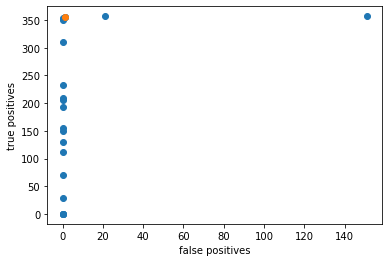

In [14]:
true_positives = []
false_positives = []
for blobs in blobs_log_ra:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if np.min(np.square(y - spot_centers_ra[:, 0]) +
                  np.square(x - spot_centers_ra[:, 1])) < 2.0 * r:
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_ra:
    y, x, r = blob
    if np.min(np.square(y - spot_centers_ra[:, 0]) +
              np.square(x - spot_centers_ra[:, 1])) < 2.0 * r:
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

Text(0, 0.5, 'estimated intensity of closest spot')

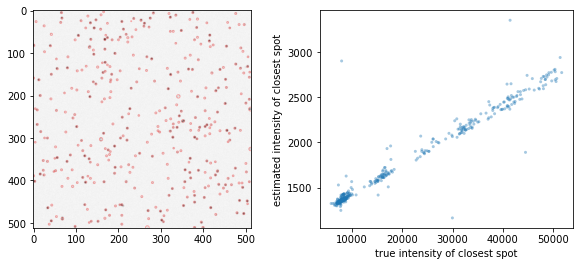

In [15]:
blobs_approx_ra = blob_log(image_approx_ra, threshold = threshold_to_use,
                           min_sigma = 0.5 * sigma_guess,
                           max_sigma = 2.0 * sigma_guess, num_sigma = 40)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(image_approx_ra, cmap = "binary")

blob_intensities_approx_ra = []
closest_intensities_approx_ra = []
for blob in blobs_approx_ra:
    y, x, r = blob
    blob_intensities_approx_ra.append(gaussian_filter(image_approx_ra, r)
                                          [int(y), int(x)])
    closest_intensities_approx_ra.append(intensities_approx_ra
                                         [np.argmin(np.square(y -
                                                        spot_centers_approx_ra
                                                            [:, 0]) +
                                                    np.square(x -
                                                        spot_centers_approx_ra
                                                            [:, 1]))])
    c = plt.Circle((x, y), r * np.sqrt(2), color = "red", linewidth = 1,
                   fill = False, alpha = 0.3)
    axes[0].add_patch(c)

axes[1].scatter(closest_intensities_approx_ra, blob_intensities_approx_ra,
                alpha = 0.4, edgecolor = "none", marker = '.')
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

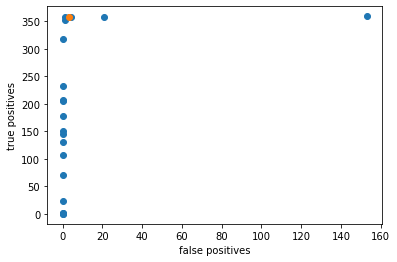

In [16]:
true_positives = []
false_positives = []
for blobs in blobs_log_approx_ra:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if np.min(np.square(y - spot_centers_approx_ra[:, 0]) +
                  np.square(x - spot_centers_approx_ra[:, 1])) < 2.0 * r:
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_approx_ra:
    y, x, r = blob
    if np.min(np.square(y - spot_centers_approx_ra[:, 0]) +
              np.square(x - spot_centers_approx_ra[:, 1])) < 2.0 * r:
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

In [17]:
@jit(nopython = True)
def pick_background_pixels(image, blobs):
    background_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for blob in blobs:
                y, x, blob_sigma = blob
                if np.sqrt(np.square(y - i) +
                           np.square(x - j)) < 4.0 * blob_sigma:
                    background_pixels.append(image[i, j])
    return background_pixels

In [18]:
def pick_background_pixels_after_subtracting(image, blobs,
                                             intensities, background_level):
    spot_images_estimated = np.zeros((num_spots, *image.shape))
    for i, blob in enumerate(blobs):
        y, x, blob_sigma = blob
        spot_images_estimated[i] = ((intensities[i] - background_level) *
                                    2.0 * np.pi * np.square(blob_sigma) *
                                    (norm.cdf(yvals_upper, y, blob_sigma) -
                                     norm.cdf(yvals_lower, y, blob_sigma))
                                        [:, np.newaxis] *
                                    (norm.cdf(xvals_upper, x, blob_sigma) -
                                     norm.cdf(xvals_lower, x, blob_sigma))
                                        [np.newaxis, :])
    image_estimated = image - np.sum(spot_images_estimated, axis = 0)
    background_pixels = pick_background_pixels(image_estimated, blobs)
    return background_pixels, image_estimated

In [19]:
modelcode = """
data {
    int<lower=1> num_background_pixels;
    vector<lower=0>[num_background_pixels] background_pixels;
}

parameters {
    real<lower=0> background_mu;
    real<lower=0> background_sigma;
}

model {
    background_pixels ~ lognormal(background_mu, background_sigma);
}
"""

filename = "fit_background.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

background_model = CmdStanModel(stan_file = filename)
background_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_background
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_background
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_background


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,639.184000,0.033046,0.985728,637.23700,639.480000,640.14400,889.740,3200.5,1.00112
background_mu,7.003200,0.000039,0.002423,6.99919,7.003190,7.00726,3923.450,14113.1,1.00071
background_sigma,0.048864,0.000070,0.001751,0.04598,0.048876,0.05175,630.477,2267.9,1.00138


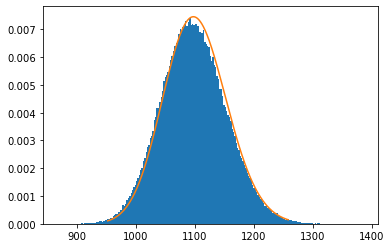

In [20]:
num_background_pixels_demo = 400
data = {"num_background_pixels": num_background_pixels_demo,
        "background_pixels": background.flatten()[:num_background_pixels_demo]}

background_fit = background_model.sample(data)
background_mle = background_model.optimize(data)

plt.hist(background.flatten(), bins = "auto", density = True)
xvals = np.linspace(np.min(background.flatten()[:num_background_pixels_demo]),
                    np.max(background.flatten()[:num_background_pixels_demo]),
                    10000)
plt.plot(xvals, lognorm.pdf(xvals,
                            s = background_mle.optimized_params_dict
                                    ["background_sigma"],
                            scale = np.exp(background_mle.optimized_params_dict
                                               ["background_mu"])))
background_fit.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,1730.470000,0.035476,1.038280,1728.400000,1730.790000,1731.450000,856.559,14.60310,1.004450
background_mu,7.127610,0.000018,0.001116,7.125770,7.127610,7.129440,3683.090,62.79140,0.999905
background_sigma,0.232607,0.000035,0.000816,0.231323,0.232579,0.234002,533.833,9.10108,1.004000


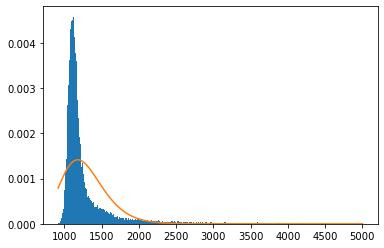

In [21]:
background_pixels_md = pick_background_pixels(image_md, blobs_md)

data = {"num_background_pixels": len(background_pixels_md),
        "background_pixels": background_pixels_md}

background_fit_md = background_model.sample(data)
background_mle_md = background_model.optimize(data)

plt.hist(background_pixels_md, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_md),
                    np.max(background_pixels_md), 10000)
plt.plot(xvals, lognorm.pdf(xvals,
                            s = background_mle_md.optimized_params_dict
                                    ["background_sigma"],
                            scale = np.exp(background_mle_md
                                               .optimized_params_dict
                                               ["background_mu"])))
background_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,14568.800000,0.040039,1.013950,14566.700000,14569.100000,14569.700000,641.322,8.39241,1.00571
background_mu,7.082960,0.000013,0.000824,7.081550,7.082970,7.084290,3808.630,49.84010,1.00014
background_sigma,0.173338,0.000028,0.000577,0.172416,0.173313,0.174346,411.404,5.38367,1.01448


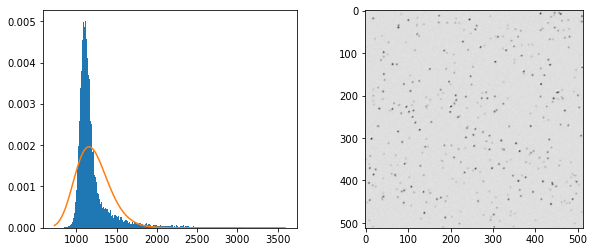

In [22]:
background_pixels_md, image_estimated_md = \
    pick_background_pixels_after_subtracting(image_md, blobs_md,
                                             blob_intensities_md,
                                             np.exp(background_mle_md
                                                        .optimized_params_dict
                                                        ["background_mu"]))

data = {"num_background_pixels": len(background_pixels_md),
        "background_pixels": background_pixels_md}

background_fit_md = background_model.sample(data)
background_mle_md = background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(background_pixels_md, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_md),
                    np.max(background_pixels_md), 10000)
axes[0].plot(xvals, lognorm.pdf(xvals,
                                s = background_mle_md.optimized_params_dict
                                        ["background_sigma"],
                                scale = np.exp(background_mle_md
                                                   .optimized_params_dict
                                                   ["background_mu"])))
axes[1].imshow(image_estimated_md, cmap = "binary")
background_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,1836.990000,0.037387,1.060490,1834.93000,1837.310000,1837.990000,804.582,14.1296,1.00272
background_mu,7.124930,0.000020,0.001138,7.12307,7.124940,7.126750,3229.550,56.7154,1.00111
background_sigma,0.232133,0.000030,0.000793,0.23081,0.232143,0.233448,717.027,12.5920,1.00615


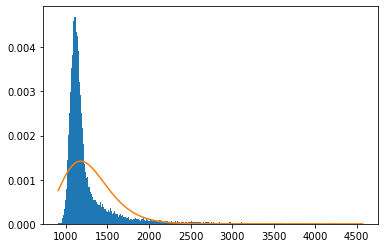

In [23]:
background_pixels_ra = pick_background_pixels(image_ra, blobs_ra)

data = {"num_background_pixels": len(background_pixels_ra),
        "background_pixels": background_pixels_ra}

background_fit_ra = background_model.sample(data)
background_mle_ra = background_model.optimize(data)

plt.hist(background_pixels_ra, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_ra),
                    np.max(background_pixels_ra), 10000)
plt.plot(xvals, lognorm.pdf(xvals,
                            s = background_mle_ra.optimized_params_dict
                                    ["background_sigma"],
                            scale = np.exp(background_mle_ra
                                               .optimized_params_dict
                                               ["background_mu"])))
background_fit_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,14921.600000,0.027033,0.927022,14919.800000,14921.80000,14922.400000,1175.980,22.4942,1.002880
background_mu,7.080870,0.000013,0.000820,7.079530,7.08088,7.082200,3870.550,74.0365,0.999693
background_sigma,0.172839,0.000020,0.000547,0.171995,0.17282,0.173761,716.977,13.7144,1.003450


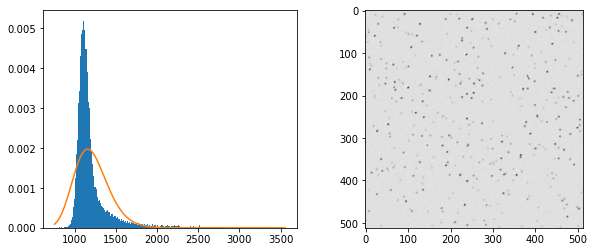

In [24]:
background_pixels_ra, image_estimated_ra = \
    pick_background_pixels_after_subtracting(image_ra, blobs_ra,
                                             blob_intensities_ra,
                                             np.exp(background_mle_ra
                                                        .optimized_params_dict
                                                        ["background_mu"]))

data = {"num_background_pixels": len(background_pixels_ra),
        "background_pixels": background_pixels_ra}

background_fit_ra = background_model.sample(data)
background_mle_ra = background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(background_pixels_ra, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_ra),
                    np.max(background_pixels_ra), 10000)
axes[0].plot(xvals, lognorm.pdf(xvals,
                                s = background_mle_ra.optimized_params_dict
                                        ["background_sigma"],
                                scale = np.exp(background_mle_ra
                                                   .optimized_params_dict
                                                   ["background_mu"])))
axes[1].imshow(image_estimated_ra, cmap = "binary")
background_fit_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,1919.390000,0.029888,0.961301,1917.420000,1919.700000,1920.300000,1034.470,18.6461,1.00210
background_mu,7.124590,0.000018,0.001097,7.122800,7.124580,7.126360,3701.250,66.7145,1.00136
background_sigma,0.231809,0.000026,0.000739,0.230562,0.231816,0.233025,838.268,15.1096,1.00187


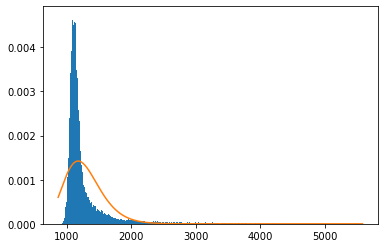

In [25]:
background_pixels_approx_ra = pick_background_pixels(image_approx_ra,
                                                     blobs_approx_ra)

data = {"num_background_pixels": len(background_pixels_approx_ra),
        "background_pixels": background_pixels_approx_ra}

background_fit_approx_ra = background_model.sample(data)
background_mle_approx_ra = background_model.optimize(data)

plt.hist(background_pixels_approx_ra, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_approx_ra),
                    np.max(background_pixels_approx_ra), 10000)
plt.plot(xvals, lognorm.pdf(xvals,
                            s = background_mle_approx_ra.optimized_params_dict
                                    ["background_sigma"],
                            scale = np.exp(background_mle_approx_ra
                                               .optimized_params_dict
                                               ["background_mu"])))
background_fit_approx_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,14759.700000,0.037274,1.033140,14757.600000,14760.000000,14760.600000,768.248,10.58430,1.00410
background_mu,7.080400,0.000013,0.000820,7.079080,7.080390,7.081730,3747.030,51.62340,0.99988
background_sigma,0.174041,0.000027,0.000587,0.173042,0.174044,0.174961,474.877,6.54244,1.00842


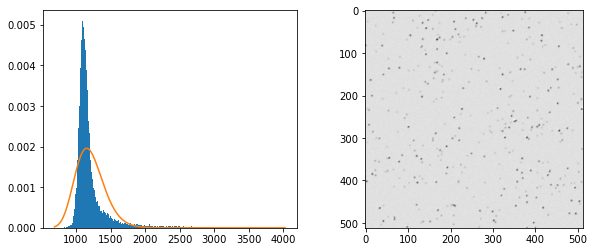

In [26]:
background_pixels_approx_ra, image_estimated_approx_ra = \
    pick_background_pixels_after_subtracting(image_approx_ra, blobs_approx_ra,
                                             blob_intensities_approx_ra,
                                             np.exp(background_mle_approx_ra
                                                        .optimized_params_dict
                                                        ["background_mu"]))
data = {"num_background_pixels": len(background_pixels_approx_ra),
        "background_pixels": background_pixels_approx_ra}

background_fit_approx_ra = background_model.sample(data)
background_mle_approx_ra = background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(background_pixels_approx_ra, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_approx_ra),
                    np.max(background_pixels_approx_ra), 10000)
axes[0].plot(xvals, lognorm.pdf(xvals,
                                s = background_mle_approx_ra
                                        .optimized_params_dict
                                        ["background_sigma"],
                                scale = np.exp(background_mle_approx_ra
                                                   .optimized_params_dict
                                                   ["background_mu"])))
axes[1].imshow(image_estimated_approx_ra, cmap = "binary")
background_fit_approx_ra.summary()

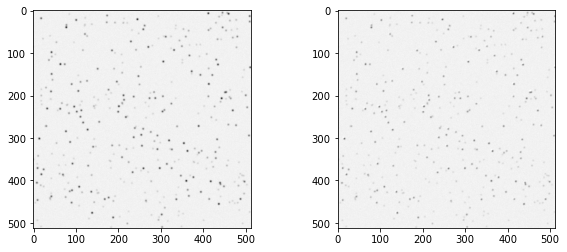

In [27]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_md, cmap = "binary",
               vmin = np.min(image_md), vmax = np.max(image_md))
axes[1].imshow(image_estimated_md, cmap = "binary",
               vmin = np.min(image_md), vmax = np.max(image_md))

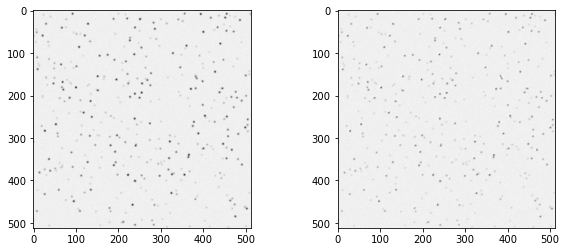

In [28]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_ra, cmap = "binary",
               vmin = np.min(image_ra), vmax = np.max(image_ra))
axes[1].imshow(image_estimated_ra, cmap = "binary",
               vmin = np.min(image_ra), vmax = np.max(image_ra))

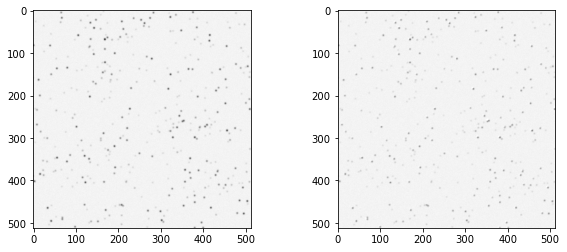

In [29]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(image_approx_ra, cmap = "binary",
               vmin = np.min(image_approx_ra), vmax = np.max(image_approx_ra))
axes[1].imshow(image_estimated_approx_ra, cmap = "binary",
               vmin = np.min(image_approx_ra), vmax = np.max(image_approx_ra))

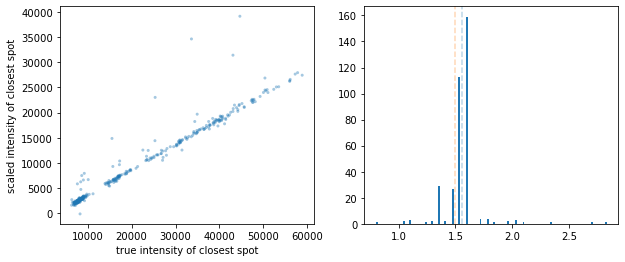

In [30]:
corrected_intensities_md = np.empty(blobs_md.shape[0])
blob_sigmas = np.empty(blobs_md.shape[0])
for i, blob in enumerate(blobs_md):
    y, x, blob_sigma = blob
    blob_sigmas[i] = blob_sigma
    corrected_intensities_md[i] = ((blob_intensities_md[i] -
                                    np.exp(background_mle_md
                                               .optimized_params_dict
                                               ["background_mu"])) *
                                   2.0 * np.pi * np.square(blob_sigma))

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].scatter(closest_intensities_md, corrected_intensities_md, alpha = 0.4,
                edgecolor = "none", marker = '.')
axes[0].set_xlabel("true intensity of closest spot")
axes[0].set_ylabel("scaled intensity of closest spot")
axes[1].hist(blob_sigmas, bins = "auto")
axes[1].axvline(np.mean(blob_sigmas), ls = "dashed", alpha = 0.3)
axes[1].axvline(spot_sigma, ls = "dashed", alpha = 0.3, color = "C1")

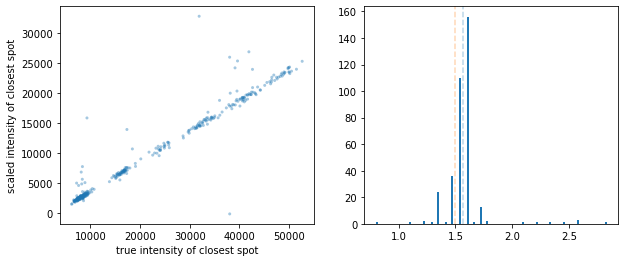

In [31]:
corrected_intensities_ra = np.empty(blobs_ra.shape[0])
blob_sigmas = np.empty(blobs_ra.shape[0])
for i, blob in enumerate(blobs_ra):
    y, x, blob_sigma = blob
    blob_sigmas[i] = blob_sigma
    corrected_intensities_ra[i] = ((blob_intensities_ra[i] -
                                    np.exp(background_mle_ra
                                               .optimized_params_dict
                                               ["background_mu"])) *
                                   2.0 * np.pi * np.square(blob_sigma))

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].scatter(closest_intensities_ra, corrected_intensities_ra,
                alpha = 0.4, edgecolor = "none", marker = '.')
axes[0].set_xlabel("true intensity of closest spot")
axes[0].set_ylabel("scaled intensity of closest spot")
axes[1].hist(blob_sigmas, bins = "auto")
axes[1].axvline(np.mean(blob_sigmas), ls = "dashed", alpha = 0.3)
axes[1].axvline(spot_sigma, ls = "dashed", alpha = 0.3, color = "C1")

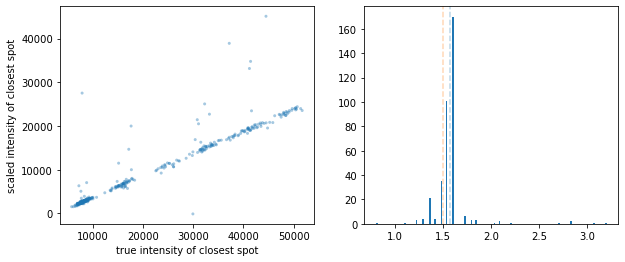

In [32]:
corrected_intensities_approx_ra = np.empty(blobs_approx_ra.shape[0])
blob_sigmas = np.empty(blobs_approx_ra.shape[0])
for i, blob in enumerate(blobs_approx_ra):
    y, x, blob_sigma = blob
    blob_sigmas[i] = blob_sigma
    corrected_intensities_approx_ra[i] = ((blob_intensities_approx_ra[i] -
                                           np.exp(background_mle_approx_ra
                                                      .optimized_params_dict
                                                      ["background_mu"])) *
                                          2.0 * np.pi * np.square(blob_sigma))

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].scatter(closest_intensities_approx_ra, corrected_intensities_approx_ra,
                alpha = 0.4, edgecolor = "none", marker = '.')
axes[0].set_xlabel("true intensity of closest spot")
axes[0].set_ylabel("scaled intensity of closest spot")
axes[1].hist(blob_sigmas, bins = "auto")
axes[1].axvline(np.mean(blob_sigmas), ls = "dashed", alpha = 0.3)
axes[1].axvline(spot_sigma, ls = "dashed", alpha = 0.3, color = "C1")

In [33]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer)
            lps[j] += lognormal_lpdf(spot_intensities[i] - background_level |
                                     monomer_mu + log(j), sigma);
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_md.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

md_model = CmdStanModel(stan_file = filename)
md_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_md
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_md
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_md


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


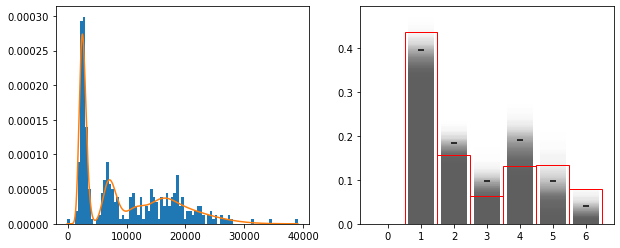

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3508.200000,0.051129,2.116120,-3512.210000,-3507.860000,-3505.420000,1712.92,72.1504,1.001790
background_level,-2036.350000,3.780200,163.598000,-2299.950000,-2034.220000,-1773.120000,1872.94,78.8907,0.999387
monomer_mu,8.451590,0.000734,0.031660,8.399550,8.452080,8.502830,1858.22,78.2707,0.999266
sigma,0.123604,0.000150,0.007401,0.112298,0.123036,0.136728,2423.98,102.1010,1.000250
p_oligomer[1],0.390000,0.000460,0.026000,0.350000,0.390000,0.440000,3335.00,140.0000,1.000000
p_oligomer[2],0.180000,0.000350,0.020000,0.150000,0.180000,0.220000,3383.00,143.0000,1.000000
p_oligomer[3],0.097000,0.000370,0.022000,0.063000,0.097000,0.130000,3428.00,144.0000,1.000000
p_oligomer[4],0.190000,0.000580,0.033000,0.130000,0.190000,0.240000,3116.00,131.0000,1.000000
p_oligomer[5],0.096000,0.000680,0.033000,0.046000,0.094000,0.150000,2335.00,98.0000,1.000000


In [34]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
md_model_fit_md = md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(md_model_fit_md.draws()[:,:,md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(md_model_fit_md.draws()[:,:,md_model_fit_md.column_names.index("background_level")]), s = np.mean(md_model_fit_md.draws()[:,:,md_model_fit_md.column_names.index("sigma")]), scale = (i + 1) * np.exp(np.mean(md_model_fit_md.draws()[:,:,md_model_fit_md.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in md_model_fit_md.draws().reshape(-1, md_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(md_model_fit_md.draws().reshape(-1, md_model_fit_md.draws().shape[-1])[:,md_model_fit_md.column_names.index("p_oligomer[1]"):md_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

md_model_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


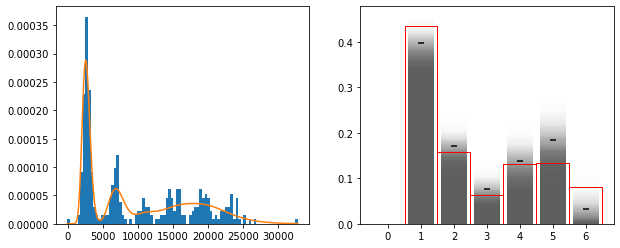

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3485.97000,0.048893,2.076500,-3489.88000,-3485.630000,-3483.240000,1803.71,86.9930,1.000840
background_level,-1668.26000,2.938800,132.036000,-1877.24000,-1671.240000,-1445.200000,2018.57,97.3557,1.000480
monomer_mu,8.38300,0.000619,0.027425,8.33610,8.383850,8.425800,1959.91,94.5262,1.000570
sigma,0.12672,0.000138,0.007439,0.11544,0.126135,0.139519,2922.54,140.9540,0.999612
p_oligomer[1],0.40000,0.000470,0.026000,0.35000,0.400000,0.440000,3114.00,150.0000,1.000000
p_oligomer[2],0.17000,0.000350,0.020000,0.14000,0.170000,0.200000,3383.00,163.0000,1.000000
p_oligomer[3],0.07600,0.000310,0.018000,0.04900,0.076000,0.110000,3264.00,157.0000,1.000000
p_oligomer[4],0.14000,0.000540,0.029000,0.09100,0.140000,0.190000,2906.00,140.0000,1.000000
p_oligomer[5],0.19000,0.000550,0.034000,0.13000,0.180000,0.240000,3672.00,177.0000,1.000000


In [35]:
data = {"num_spots": corrected_intensities_ra.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_ra - np.min(corrected_intensities_ra)}
md_model_fit_ra = md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_ra, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_ra),
                    np.max(corrected_intensities_ra), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(md_model_fit_ra.draws()[:,:,md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_ra) - np.mean(md_model_fit_ra.draws()[:,:,md_model_fit_ra.column_names.index("background_level")]), s = np.mean(md_model_fit_ra.draws()[:,:,md_model_fit_ra.column_names.index("sigma")]), scale = (i + 1) * np.exp(np.mean(md_model_fit_ra.draws()[:,:,md_model_fit_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in md_model_fit_ra.draws().reshape(-1, md_model_fit_ra.draws().shape[-1])[::25,:]:
    heights = [draw[md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(md_model_fit_ra.draws().reshape(-1, md_model_fit_ra.draws().shape[-1])[:,md_model_fit_ra.column_names.index("p_oligomer[1]"):md_model_fit_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

md_model_fit_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


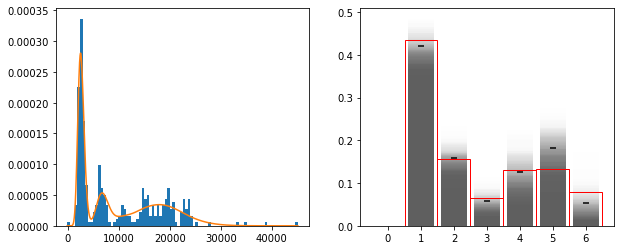

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3542.030000,0.061366,2.171350,-3546.150000,-3541.650000,-3539.200000,1251.98,61.0872,1.00370
background_level,-1602.900000,4.381850,157.790000,-1851.130000,-1607.450000,-1339.400000,1296.71,63.2696,1.00368
monomer_mu,8.367160,0.000947,0.033828,8.309720,8.368840,8.419900,1275.54,62.2367,1.00336
sigma,0.140454,0.000228,0.009250,0.126128,0.139717,0.156542,1639.31,79.9856,1.00497
p_oligomer[1],0.420000,0.000450,0.025000,0.380000,0.420000,0.460000,3049.00,149.0000,1.00000
p_oligomer[2],0.160000,0.000360,0.020000,0.130000,0.160000,0.190000,2982.00,146.0000,1.00000
p_oligomer[3],0.058000,0.000400,0.019000,0.029000,0.057000,0.090000,2150.00,105.0000,1.00000
p_oligomer[4],0.130000,0.000790,0.037000,0.064000,0.130000,0.190000,2197.00,107.0000,1.00000
p_oligomer[5],0.180000,0.000800,0.040000,0.120000,0.180000,0.250000,2461.00,120.0000,1.00000


In [36]:
data = {"num_spots": corrected_intensities_approx_ra.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_approx_ra - np.min(corrected_intensities_approx_ra)}
md_model_fit_approx_ra = md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_approx_ra, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_approx_ra),
                    np.max(corrected_intensities_approx_ra), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(md_model_fit_approx_ra.draws()[:,:,md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_approx_ra) - np.mean(md_model_fit_approx_ra.draws()[:,:,md_model_fit_approx_ra.column_names.index("background_level")]), s = np.mean(md_model_fit_approx_ra.draws()[:,:,md_model_fit_approx_ra.column_names.index("sigma")]), scale = (i + 1) * np.exp(np.mean(md_model_fit_approx_ra.draws()[:,:,md_model_fit_approx_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in md_model_fit_approx_ra.draws().reshape(-1, md_model_fit_approx_ra.draws().shape[-1])[::25,:]:
    heights = [draw[md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(md_model_fit_approx_ra.draws().reshape(-1, md_model_fit_approx_ra.draws().shape[-1])[:,md_model_fit_approx_ra.column_names.index("p_oligomer[1]"):md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

md_model_fit_approx_ra.summary()

In [37]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer)
            lps[j] += lognormal_lpdf(spot_intensities[i] - background_level |
                                     monomer_mu + log(j), sigma / sqrt(j));
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_approx_ra.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

approx_ra_model = CmdStanModel(stan_file = filename)
approx_ra_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_approx_ra
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_approx_ra
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_approx_ra


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


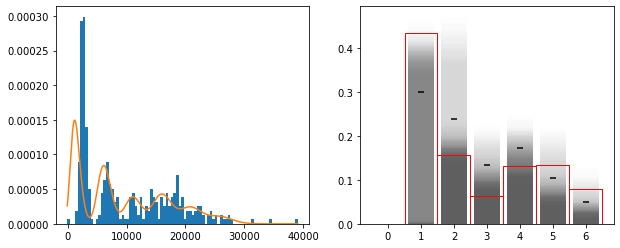

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3545.340000,15.030700,21.366800,-3583.770000,-3533.600000,-3530.480000,2.02080,0.102195,11.07990
background_level,-3552.010000,1690.340000,2400.090000,-7929.530000,-2238.140000,-1937.190000,2.01609,0.101956,13.37770
monomer_mu,8.507380,0.023914,0.040464,8.449990,8.499730,8.581790,2.86316,0.144794,1.76099
sigma,0.163335,0.001885,0.009683,0.148287,0.162884,0.179874,26.37900,1.334020,1.04650
p_oligomer[1],0.300000,0.120000,0.170000,0.000490,0.390000,0.440000,2.00000,0.100000,8.40000
p_oligomer[2],0.240000,0.070000,0.100000,0.150000,0.190000,0.430000,2.10000,0.110000,4.80000
p_oligomer[3],0.130000,0.022000,0.037000,0.087000,0.130000,0.200000,2.80000,0.140000,1.80000
p_oligomer[4],0.170000,0.016000,0.031000,0.120000,0.170000,0.220000,3.80000,0.190000,1.40000
p_oligomer[5],0.110000,0.031000,0.047000,0.054000,0.087000,0.200000,2.30000,0.120000,2.50000


In [38]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
approx_ra_model_fit_md = approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(approx_ra_model_fit_md.draws()[:,:,approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(approx_ra_model_fit_md.draws()[:,:,approx_ra_model_fit_md.column_names.index("background_level")]), s = np.mean(approx_ra_model_fit_md.draws()[:,:,approx_ra_model_fit_md.column_names.index("sigma")]) / np.sqrt(i + 1), scale = (i + 1) * np.exp(np.mean(approx_ra_model_fit_md.draws()[:,:,approx_ra_model_fit_md.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in approx_ra_model_fit_md.draws().reshape(-1, approx_ra_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(approx_ra_model_fit_md.draws().reshape(-1, approx_ra_model_fit_md.draws().shape[-1])[:,approx_ra_model_fit_md.column_names.index("p_oligomer[1]"):approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

approx_ra_model_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


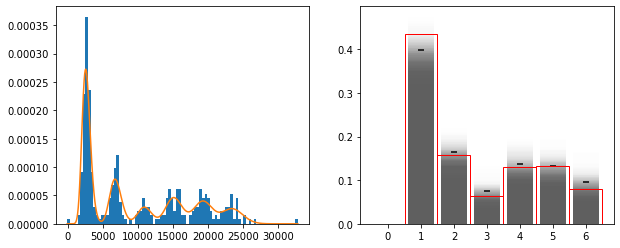

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3471.550000,0.045640,2.011570,-3475.310000,-3471.240000,-3468.900000,1942.57,98.5975,1.000120
background_level,-1469.780000,1.171430,69.735600,-1585.250000,-1469.080000,-1355.940000,3543.83,179.8710,1.000890
monomer_mu,8.338620,0.000173,0.009672,8.322580,8.338640,8.354680,3110.32,157.8680,1.000790
sigma,0.141037,0.000103,0.006393,0.130816,0.140708,0.151744,3856.27,195.7300,0.999707
p_oligomer[1],0.400000,0.000420,0.026000,0.360000,0.400000,0.440000,3812.00,193.0000,1.000000
p_oligomer[2],0.160000,0.000310,0.020000,0.130000,0.160000,0.200000,4060.00,206.0000,1.000000
p_oligomer[3],0.075000,0.000210,0.014000,0.053000,0.074000,0.099000,4552.00,231.0000,1.000000
p_oligomer[4],0.140000,0.000290,0.019000,0.110000,0.130000,0.170000,4219.00,214.0000,1.000000
p_oligomer[5],0.130000,0.000300,0.020000,0.100000,0.130000,0.170000,4214.00,214.0000,1.000000


In [39]:
data = {"num_spots": corrected_intensities_ra.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_ra - np.min(corrected_intensities_ra)}
approx_ra_model_fit_ra = approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_ra, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_ra),
                    np.max(corrected_intensities_ra), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(approx_ra_model_fit_ra.draws()[:,:,approx_ra_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_ra) - np.mean(approx_ra_model_fit_ra.draws()[:,:,approx_ra_model_fit_ra.column_names.index("background_level")]), s = np.mean(approx_ra_model_fit_ra.draws()[:,:,approx_ra_model_fit_ra.column_names.index("sigma")]) / np.sqrt(i + 1), scale = (i + 1) * np.exp(np.mean(approx_ra_model_fit_ra.draws()[:,:,approx_ra_model_fit_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in approx_ra_model_fit_ra.draws().reshape(-1, approx_ra_model_fit_ra.draws().shape[-1])[::25,:]:
    heights = [draw[approx_ra_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(approx_ra_model_fit_ra.draws().reshape(-1, approx_ra_model_fit_ra.draws().shape[-1])[:,approx_ra_model_fit_ra.column_names.index("p_oligomer[1]"):approx_ra_model_fit_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

approx_ra_model_fit_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


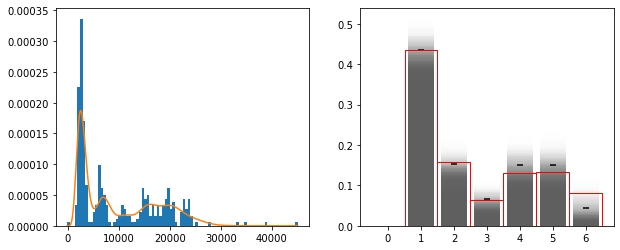

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3583.81000,0.059778,2.178610,-3587.89000,-3583.440000,-3581.000000,1328.24,77.3985,1.00174
background_level,-1628.60000,4.601400,180.814000,-1928.17000,-1630.710000,-1332.020000,1544.13,89.9788,1.00291
monomer_mu,8.40478,0.000826,0.032892,8.35145,8.405540,8.458450,1585.58,92.3942,1.00157
sigma,0.21214,0.000375,0.016777,0.18945,0.210163,0.242172,2006.22,116.9060,1.00032
p_oligomer[1],0.44000,0.000430,0.027000,0.39000,0.440000,0.480000,3862.00,225.0000,1.00000
p_oligomer[2],0.15000,0.000330,0.021000,0.12000,0.150000,0.190000,4144.00,241.0000,1.00000
p_oligomer[3],0.06500,0.000270,0.016000,0.04000,0.064000,0.094000,3699.00,216.0000,1.00000
p_oligomer[4],0.15000,0.000470,0.027000,0.11000,0.150000,0.200000,3290.00,192.0000,1.00000
p_oligomer[5],0.15000,0.000380,0.026000,0.11000,0.150000,0.190000,4636.00,270.0000,1.00000


In [40]:
data = {"num_spots": corrected_intensities_approx_ra.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_approx_ra - np.min(corrected_intensities_approx_ra)}
approx_ra_model_fit_approx_ra = approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_approx_ra, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_approx_ra),
                    np.max(corrected_intensities_approx_ra), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(approx_ra_model_fit_approx_ra.draws()[:,:,approx_ra_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * lognorm.pdf(xvals - np.min(corrected_intensities_approx_ra) - np.mean(approx_ra_model_fit_approx_ra.draws()[:,:,approx_ra_model_fit_approx_ra.column_names.index("background_level")]), s = np.mean(approx_ra_model_fit_approx_ra.draws()[:,:,approx_ra_model_fit_approx_ra.column_names.index("sigma")]) / np.sqrt(i + 1), scale = (i + 1) * np.exp(np.mean(approx_ra_model_fit_approx_ra.draws()[:,:,approx_ra_model_fit_approx_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in approx_ra_model_fit_approx_ra.draws().reshape(-1, approx_ra_model_fit_approx_ra.draws().shape[-1])[::25,:]:
    heights = [draw[approx_ra_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(approx_ra_model_fit_approx_ra.draws().reshape(-1, approx_ra_model_fit_approx_ra.draws().shape[-1])[:,approx_ra_model_fit_approx_ra.column_names.index("p_oligomer[1]"):approx_ra_model_fit_approx_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

approx_ra_model_fit_approx_ra.summary()

In [41]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[(highest_oligomer * (highest_oligomer + 1) / 2)] lps;
    int ravel;
    for (i in 1:num_spots) {
        ravel = 1;
        for (k in 1:highest_oligomer) { // num total
            for (j in 1:k) { // num bright
                lps[ravel] = log_p_oligomer[k];
                // subtracting the log complementary CDF accounts for
                // the 0 population being censored
                lps[ravel] += binomial_lpmf(j | k, p_bright) -
                              binomial_lccdf(0 | k, p_bright);
                lps[ravel] += lognormal_lpdf(spot_intensities[i] -
                                             background_level |
                                             monomer_mu + log(j), sigma);
                ravel += 1;
            }
        }
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_combined_md.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

combined_md_model = CmdStanModel(stan_file = filename)
combined_md_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_combined_md
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_combined_md
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_combined_md


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


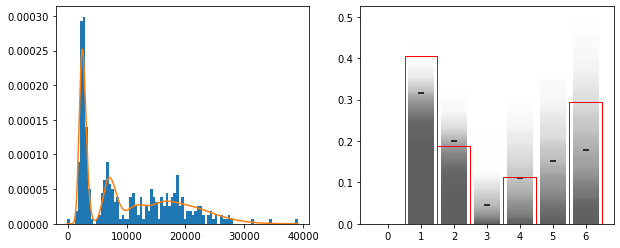

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3511.210000,0.067600,2.418460,-3515.650000,-3510.820000,-3507.990000,1279.94,3.62983,1.00190
background_level,-2050.650000,3.748230,164.336000,-2314.380000,-2051.890000,-1779.840000,1922.26,5.45141,1.00116
monomer_mu,8.454270,0.000718,0.031761,8.402080,8.455030,8.504470,1959.54,5.55714,1.00131
sigma,0.122535,0.000149,0.007301,0.111863,0.121811,0.135009,2398.09,6.80085,1.00027
p_oligomer[1],0.310000,0.001200,0.047000,0.230000,0.320000,0.390000,1537.00,4.40000,1.00000
p_oligomer[2],0.200000,0.001100,0.045000,0.130000,0.200000,0.270000,1538.00,4.40000,1.00000
p_oligomer[3],0.046000,0.000880,0.037000,0.003000,0.038000,0.120000,1710.00,4.90000,1.00000
p_oligomer[4],0.110000,0.001700,0.079000,0.006600,0.098000,0.250000,2057.00,5.80000,1.00000
p_oligomer[5],0.150000,0.001500,0.086000,0.022000,0.150000,0.300000,3111.00,8.80000,1.00000


In [42]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
combined_md_model_fit_md = combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(combined_md_model_fit_md.draws()[:,:,combined_md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(combined_md_model_fit_md.draws()[:,:,combined_md_model_fit_md.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(combined_md_model_fit_md.draws()[:,:,combined_md_model_fit_md.column_names.index("background_level")]), s = np.mean(combined_md_model_fit_md.draws()[:,:,combined_md_model_fit_md.column_names.index("sigma")]), scale = (j + 1) * np.exp(np.mean(combined_md_model_fit_md.draws()[:,:,combined_md_model_fit_md.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_md.draws().reshape(-1, combined_md_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[combined_md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(combined_md_model_fit_md.draws().reshape(-1, combined_md_model_fit_md.draws().shape[-1])[:,combined_md_model_fit_md.column_names.index("p_oligomer[1]"):combined_md_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

combined_md_model_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


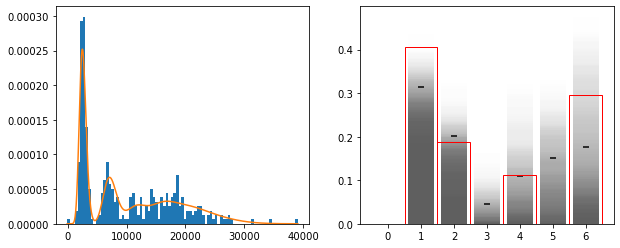

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3510.99000,0.059772,2.269580,-3515.330000,-3510.620000,-3507.95000,1441.75,4.09818,1.002940
background_level,-2050.04000,3.610850,161.035000,-2309.390000,-2054.520000,-1783.34000,1988.94,5.65354,0.999335
monomer_mu,8.45423,0.000696,0.031073,8.402800,8.455350,8.50344,1992.21,5.66283,0.999497
sigma,0.12259,0.000134,0.006842,0.111925,0.122474,0.13435,2625.90,7.46411,1.001200
p_oligomer[1],0.32000,0.001200,0.045000,0.240000,0.320000,0.39000,1376.00,3.90000,1.000000
p_oligomer[2],0.20000,0.000930,0.042000,0.130000,0.200000,0.27000,2064.00,5.90000,1.000000
p_oligomer[3],0.04500,0.000780,0.035000,0.003500,0.037000,0.11000,2039.00,5.80000,1.000000
p_oligomer[4],0.11000,0.001900,0.080000,0.006900,0.096000,0.25000,1748.00,5.00000,1.000000
p_oligomer[5],0.15000,0.001700,0.086000,0.020000,0.150000,0.30000,2649.00,7.50000,1.000000


In [43]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
combined_md_model_fit_ra = combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(combined_md_model_fit_ra.draws()[:,:,combined_md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(combined_md_model_fit_ra.draws()[:,:,combined_md_model_fit_ra.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(combined_md_model_fit_ra.draws()[:,:,combined_md_model_fit_ra.column_names.index("background_level")]), s = np.mean(combined_md_model_fit_ra.draws()[:,:,combined_md_model_fit_ra.column_names.index("sigma")]), scale = (j + 1) * np.exp(np.mean(combined_md_model_fit_ra.draws()[:,:,combined_md_model_fit_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_ra.draws().reshape(-1, combined_md_model_fit_ra.draws().shape[-1])[::25,:]:
    heights = [draw[combined_md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(combined_md_model_fit_ra.draws().reshape(-1, combined_md_model_fit_ra.draws().shape[-1])[:,combined_md_model_fit_ra.column_names.index("p_oligomer[1]"):combined_md_model_fit_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

combined_md_model_fit_ra.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


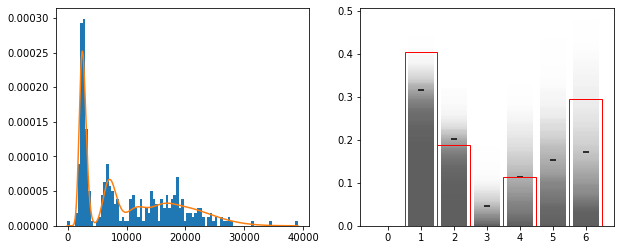

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3510.930000,0.061085,2.249360,-3515.260000,-3510.580000,-3507.910000,1355.96,3.81564,1.00557
background_level,-2055.380000,3.719590,164.827000,-2327.130000,-2056.140000,-1774.060000,1963.65,5.52566,1.00172
monomer_mu,8.455080,0.000712,0.031677,8.401530,8.456380,8.505810,1981.85,5.57687,1.00184
sigma,0.122407,0.000136,0.006951,0.111861,0.121957,0.134711,2598.97,7.31342,1.00146
p_oligomer[1],0.320000,0.001200,0.046000,0.240000,0.320000,0.390000,1591.00,4.50000,1.00000
p_oligomer[2],0.200000,0.001100,0.043000,0.130000,0.200000,0.270000,1500.00,4.20000,1.00000
p_oligomer[3],0.046000,0.000880,0.036000,0.003100,0.038000,0.110000,1714.00,4.80000,1.00000
p_oligomer[4],0.110000,0.001900,0.079000,0.007700,0.100000,0.250000,1666.00,4.70000,1.00000
p_oligomer[5],0.150000,0.001800,0.084000,0.021000,0.150000,0.300000,2280.00,6.40000,1.00000


In [44]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
combined_md_model_fit_approx_ra = combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(combined_md_model_fit_approx_ra.draws()[:,:,combined_md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(combined_md_model_fit_approx_ra.draws()[:,:,combined_md_model_fit_approx_ra.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(combined_md_model_fit_approx_ra.draws()[:,:,combined_md_model_fit_approx_ra.column_names.index("background_level")]), s = np.mean(combined_md_model_fit_approx_ra.draws()[:,:,combined_md_model_fit_approx_ra.column_names.index("sigma")]), scale = (j + 1) * np.exp(np.mean(combined_md_model_fit_approx_ra.draws()[:,:,combined_md_model_fit_approx_ra.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_approx_ra.draws().reshape(-1, combined_md_model_fit_approx_ra.draws().shape[-1])[::25,:]:
    heights = [draw[combined_md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(combined_md_model_fit_approx_ra.draws().reshape(-1, combined_md_model_fit_approx_ra.draws().shape[-1])[:,combined_md_model_fit_approx_ra.column_names.index("p_oligomer[1]"):combined_md_model_fit_approx_ra.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

combined_md_model_fit_approx_ra.summary()

In [45]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[(highest_oligomer * (highest_oligomer + 1) / 2)] lps;
    int ravel;
    for (i in 1:num_spots) {
        ravel = 1;
        for (k in 1:highest_oligomer) { // num total
            for (j in 1:k) { // num bright
                lps[ravel] = log_p_oligomer[k];
                // subtracting the log complementary CDF accounts for
                // the 0 population being censored
                lps[ravel] += binomial_lpmf(j | k, p_bright) -
                              binomial_lccdf(0 | k, p_bright);
                lps[ravel] += lognormal_lpdf(spot_intensities[i] -
                                             background_level |
                                             monomer_mu + log(j),
                                             sigma / sqrt(j));
                ravel += 1;
            }
        }
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_combined_approx_ra.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

combined_approx_ra_model = CmdStanModel(stan_file = filename)
combined_approx_ra_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_combined_approx_ra
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_combined_approx_ra
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_combined_approx_ra


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


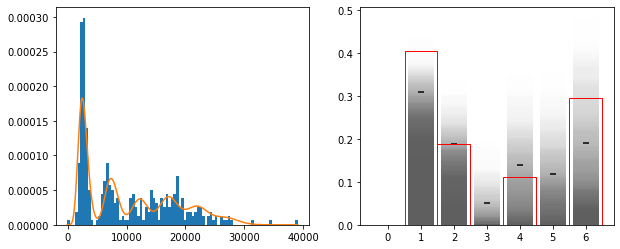

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3536.060000,0.068956,2.297370,-3540.250000,-3535.730000,-3532.940000,1109.98,3.31730,1.00108
background_level,-2216.300000,3.704330,159.164000,-2467.720000,-2222.880000,-1940.080000,1846.17,5.51747,1.00369
monomer_mu,8.496630,0.000586,0.025521,8.450920,8.498270,8.535270,1898.75,5.67460,1.00368
sigma,0.162989,0.000186,0.008853,0.149289,0.162618,0.178072,2271.40,6.78832,1.00015
p_oligomer[1],0.310000,0.001200,0.046000,0.230000,0.310000,0.380000,1558.00,4.70000,1.00000
p_oligomer[2],0.190000,0.001300,0.049000,0.110000,0.190000,0.270000,1394.00,4.20000,1.00000
p_oligomer[3],0.052000,0.000960,0.041000,0.003000,0.043000,0.130000,1845.00,5.50000,1.00000
p_oligomer[4],0.140000,0.002000,0.085000,0.013000,0.140000,0.270000,1862.00,5.60000,1.00000
p_oligomer[5],0.120000,0.001300,0.072000,0.016000,0.110000,0.260000,2972.00,8.90000,1.00000


In [46]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
combined_approx_ra_model_fit_md = combined_approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(combined_approx_ra_model_fit_md.draws()[:,:,combined_approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(combined_approx_ra_model_fit_md.draws()[:,:,combined_approx_ra_model_fit_md.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(combined_approx_ra_model_fit_md.draws()[:,:,combined_approx_ra_model_fit_md.column_names.index("background_level")]), s = np.mean(combined_approx_ra_model_fit_md.draws()[:,:,combined_approx_ra_model_fit_md.column_names.index("sigma")]) / np.sqrt(j + 1), scale = (j + 1) * np.exp(np.mean(combined_approx_ra_model_fit_md.draws()[:,:,combined_approx_ra_model_fit_md.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_approx_ra_model_fit_md.draws().reshape(-1, combined_approx_ra_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[combined_approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(combined_approx_ra_model_fit_md.draws().reshape(-1, combined_approx_ra_model_fit_md.draws().shape[-1])[:,combined_approx_ra_model_fit_md.column_names.index("p_oligomer[1]"):combined_approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

combined_approx_ra_model_fit_md.summary()

In [47]:
# A model which uses a Dirichlet prior to encourage concentration
# of the oligomeric probabilities into fewer states

modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[(highest_oligomer * (highest_oligomer + 1) / 2)] lps;
    int ravel;
    for (i in 1:num_spots) {
        ravel = 1;
        for (k in 1:highest_oligomer) { // num total
            for (j in 1:k) { // num bright
                lps[ravel] = log_p_oligomer[k];
                // subtracting the log complementary CDF accounts for
                // the 0 population being censored
                lps[ravel] += binomial_lpmf(j | k, p_bright) -
                              binomial_lccdf(0 | k, p_bright);
                lps[ravel] += lognormal_lpdf(spot_intensities[i] -
                                             background_level |
                                             monomer_mu + log(j), sigma);
                ravel += 1;
            }
        }
        target += log_sum_exp(lps);
    }
    // Dirichlet prior to favor "sparse" solutions to oligomer distribution:
    p_oligomer ~ dirichlet(rep_vector(0.2, highest_oligomer));
}
"""

filename = "fit_prior_combined_md.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

prior_combined_md_model = CmdStanModel(stan_file = filename)
prior_combined_md_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_prior_combined_md
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_prior_combined_md
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_prior_combined_md


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


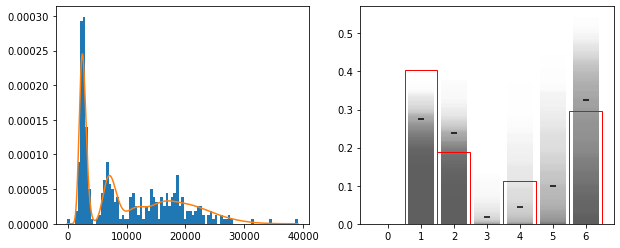

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3502.080000,0.072598,2.365210,-3.506440e+03,-3501.740000,-3498.850000,1061.43,1.86982,1.00177
background_level,-2036.860000,4.028140,161.210000,-2.298340e+03,-2037.520000,-1771.590000,1601.68,2.82153,1.00048
monomer_mu,8.451530,0.000775,0.031135,8.397970e+00,8.451970,8.502060,1613.54,2.84243,1.00058
sigma,0.122719,0.000163,0.006972,1.123090e-01,0.122215,0.134895,1836.32,3.23488,1.00055
p_oligomer[1],0.280000,0.001400,0.048000,2.000000e-01,0.280000,0.360000,1130.00,2.00000,1.00000
p_oligomer[2],0.240000,0.001700,0.054000,1.500000e-01,0.240000,0.330000,1066.00,1.90000,1.00000
p_oligomer[3],0.018000,0.000980,0.032000,9.000000e-09,0.002400,0.089000,1086.00,1.90000,1.00000
p_oligomer[4],0.043000,0.002300,0.072000,7.900000e-08,0.006200,0.220000,1010.00,1.80000,1.00000
p_oligomer[5],0.099000,0.003000,0.120000,1.300000e-06,0.043000,0.340000,1572.00,2.80000,1.00000


In [48]:
data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md)}
prior_combined_md_model_fit_md = prior_combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_md, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_md),
                    np.max(corrected_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(prior_combined_md_model_fit_md.draws()[:,:,prior_combined_md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(prior_combined_md_model_fit_md.draws()[:,:,prior_combined_md_model_fit_md.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_md) - np.mean(prior_combined_md_model_fit_md.draws()[:,:,prior_combined_md_model_fit_md.column_names.index("background_level")]), s = np.mean(prior_combined_md_model_fit_md.draws()[:,:,prior_combined_md_model_fit_md.column_names.index("sigma")]), scale = (j + 1) * np.exp(np.mean(prior_combined_md_model_fit_md.draws()[:,:,prior_combined_md_model_fit_md.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in prior_combined_md_model_fit_md.draws().reshape(-1, prior_combined_md_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[prior_combined_md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(prior_combined_md_model_fit_md.draws().reshape(-1, prior_combined_md_model_fit_md.draws().shape[-1])[:,prior_combined_md_model_fit_md.column_names.index("p_oligomer[1]"):prior_combined_md_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

prior_combined_md_model_fit_md.summary()

In [49]:
# sample log-scale (Normal) model

modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer)
            lps[j] += normal_lpdf(log(spot_intensities[i] - background_level) |
                                  monomer_mu * log(j), sigma - 0.5 * log(j));
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_log_scale.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

log_scale_model = CmdStanModel(stan_file = filename)
log_scale_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_log_scale
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_log_scale
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_log_scale


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


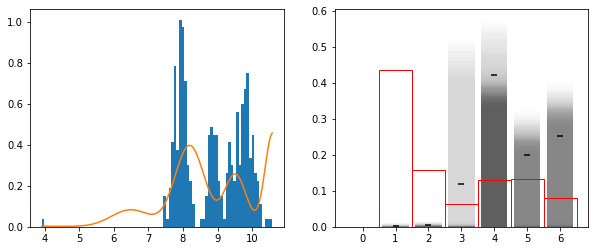

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-455.20500,12.12090,17.286600,-486.54200,-445.83600,-442.60200,2.03399,0.076314,8.12139
background_level,-49.38040,19.73890,45.257500,-135.52100,-37.90020,-1.36030,5.25693,0.197236,1.26964
monomer_mu,5.90915,0.45288,0.641708,5.51608,5.54549,7.04728,2.00775,0.075329,31.99440
sigma,1.11667,0.00052,0.015631,1.09264,1.11603,1.14336,902.21300,33.850400,1.00527
p_oligomer[1],0.00320,0.00013,0.003200,0.00014,0.00220,0.00970,583.00000,22.000000,1.00000
p_oligomer[2],0.00510,0.00013,0.003800,0.00071,0.00430,0.01300,875.00000,33.000000,1.00000
p_oligomer[3],0.12000,0.14000,0.200000,0.00022,0.00300,0.49000,2.00000,0.076000,13.00000
p_oligomer[4],0.42000,0.04100,0.064000,0.35000,0.40000,0.55000,2.40000,0.089000,2.40000
p_oligomer[5],0.20000,0.08000,0.120000,0.00065,0.25000,0.30000,2.10000,0.078000,5.40000


In [50]:
# sample log-scale (Normal) model

data = {"num_spots": corrected_intensities_md.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_md - np.min(corrected_intensities_md) + 1.0}
log_scale_model_fit_md = log_scale_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(np.log(corrected_intensities_md - np.min(corrected_intensities_md) + 1.0 - np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("background_level")])), bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(np.log(corrected_intensities_md - np.min(corrected_intensities_md) + 1.0 - np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("background_level")]))),
                    np.max(np.log(corrected_intensities_md - np.min(corrected_intensities_md) + 1.0 - np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("background_level")]))), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * norm.pdf(xvals, np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("monomer_mu")]) * np.log(i + 1), -0.5 * np.log(i + 1) + np.mean(log_scale_model_fit_md.draws()[:,:,log_scale_model_fit_md.column_names.index("sigma")]))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in log_scale_model_fit_md.draws().reshape(-1, log_scale_model_fit_md.draws().shape[-1])[::25,:]:
    heights = [draw[log_scale_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(log_scale_model_fit_md.draws().reshape(-1, log_scale_model_fit_md.draws().shape[-1])[:,log_scale_model_fit_md.column_names.index("p_oligomer[1]"):log_scale_model_fit_md.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_bright_fluorophores[num_bright_fluorophores != 0], bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

log_scale_model_fit_md.summary()

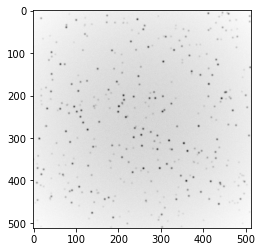

In [51]:
# example of simulating a vignetted image
vignetting_sigma = 300.0
image_vignetted_md = (image_md * 2.0 * np.pi * vignetting_sigma ** 2 *
                      (norm.cdf(yvals_upper, image_dims[0] / 2.0,
                                vignetting_sigma) -
                       norm.cdf(yvals_lower, image_dims[0] / 2.0,
                                vignetting_sigma))[:, np.newaxis] *
                      (norm.cdf(xvals_upper, image_dims[1] / 2.0,
                                vignetting_sigma) -
                       norm.cdf(xvals_lower, image_dims[1] / 2.0,
                                vignetting_sigma))[np.newaxis, :])

plt.imshow(image_vignetted_md, cmap = "binary")

Text(0, 0.5, 'estimated intensity of closest spot')

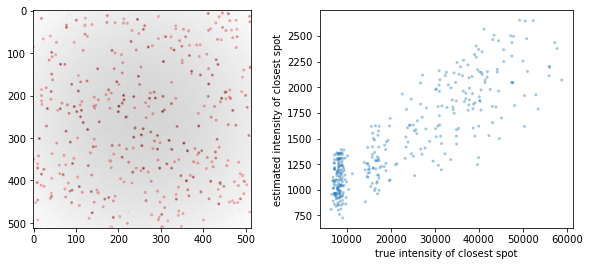

In [52]:
blobs_vignetted_md = blob_log(image_vignetted_md, threshold = threshold_to_use,
                              min_sigma = 0.5 * sigma_guess,
                              max_sigma = 2.0 * sigma_guess, num_sigma = 40)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(image_vignetted_md, cmap = "binary")

blob_intensities_vignetted_md = []
closest_intensities_vignetted_md = []
for blob in blobs_vignetted_md:
    y, x, r = blob
    blob_intensities_vignetted_md.append(gaussian_filter(image_vignetted_md, r)[int(y), int(x)])
    closest_intensities_vignetted_md.append(intensities_md
                                            [np.argmin(np.square(y -
                                                       spot_centers_md[:, 0]) +
                                             np.square(x -
                                                       spot_centers_md[:, 1]))])
    c = plt.Circle((x, y), r * np.sqrt(2), color = "red", linewidth = 1,
                   fill = False, alpha = 0.3)
    axes[0].add_patch(c)
    
axes[1].scatter(closest_intensities_vignetted_md, blob_intensities_vignetted_md, alpha = 0.4,
                edgecolor = "none", marker = '.')
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

In [53]:
modelcode = """
data {
    int<lower=1> num_background_pixels;
    vector<lower=0>[num_background_pixels] background_pixels;
    vector<lower=0>[num_background_pixels] pixel_locations[2];
    int<lower=1> max_image_dim;
}
parameters {
    real<lower=0> background_mu;
    real<lower=0> background_sigma;
    real<lower=max_image_dim / 2> background_decay;
    real<lower=0, upper=max_image_dim> background_center[2];
}
model {
    vector[num_background_pixels] distances = 
        sqrt((pixel_locations[1] - background_center[1]) ^ 2 +
             (pixel_locations[2] - background_center[2]) ^ 2);
    background_pixels ~ lognormal(background_mu - (distances / background_decay) ^ 2,
                                  background_sigma);
    background_center ~ normal(max_image_dim / 2, max_image_dim / 10);
}
"""

filename = "fit_vignetted_background.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

vignetted_background_model = CmdStanModel(stan_file = filename)
vignetted_background_model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/fit_vignetted_background
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/fit_vignetted_background
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/fit_vignetted_background


In [54]:
@jit(nopython = True)
def pick_background_pixels_locations(image, blobs):
    background_pixels = []
    background_pixel_locations = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for blob in blobs:
                y, x, blob_sigma = blob
                if np.sqrt(np.square(y - i) +
                           np.square(x - j)) < 4.0 * blob_sigma:
                    background_pixels.append(image[i, j])
                    background_pixel_locations.append((i,j))
    return background_pixels, background_pixel_locations

In [55]:
def pick_background_pixels_locations_after_subtracting(image, blobs,
                                                       intensities, background_level):
    spot_images_estimated = np.zeros((num_spots, *image.shape))
    for i, blob in enumerate(blobs):
        y, x, blob_sigma = blob
        spot_images_estimated[i] = ((intensities[i] - background_level) *
                                    2.0 * np.pi * np.square(blob_sigma) *
                                    (norm.cdf(yvals_upper, y, blob_sigma) -
                                     norm.cdf(yvals_lower, y, blob_sigma))
                                        [:, np.newaxis] *
                                    (norm.cdf(xvals_upper, x, blob_sigma) -
                                     norm.cdf(xvals_lower, x, blob_sigma))
                                        [np.newaxis, :])
    image_estimated = image - np.sum(spot_images_estimated, axis = 0)
    background_pixels, background_pixel_locations = pick_background_pixels_locations(image_estimated, blobs)
    return background_pixels, image_estimated, background_pixel_locations

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,1399.480000,0.040895,1.627200,1396.360000,1399.820000,1401.44000,1583.27,0.847139,1.002150
background_mu,7.133420,0.000041,0.002121,7.130050,7.133400,7.13697,2658.14,1.422260,0.999809
background_sigma,0.234242,0.000013,0.000823,0.232904,0.234244,0.23557,3807.23,2.037090,1.000490
background_decay,420.753000,0.031799,1.594940,418.125000,420.790000,423.31800,2515.69,1.346040,1.000280
background_center[1],252.000000,0.013000,0.730000,251.000000,252.000000,253.00000,3195.00,1.700000,1.000000
background_center[2],254.000000,0.012000,0.690000,253.000000,254.000000,256.00000,3318.00,1.800000,1.000000


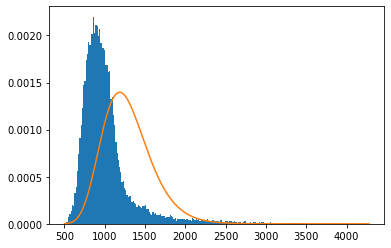

In [56]:
background_pixels_vignetted_md, background_pixel_locations_vignetted_md = \
    pick_background_pixels_locations(image_vignetted_md, blobs_vignetted_md)

data = {"num_background_pixels": len(background_pixels_vignetted_md),
        "background_pixels": background_pixels_vignetted_md,
        "pixel_locations": np.array(background_pixel_locations_vignetted_md).T,
        "max_image_dim": max(image_dims)}

vignetted_background_fit_md = vignetted_background_model.sample(data, inits = {"background_center": (image_dims[0] / 2, image_dims[1] / 2)})
vignetted_background_mle_md = vignetted_background_model.optimize(data)

plt.hist(background_pixels_vignetted_md, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_vignetted_md),
                    np.max(background_pixels_vignetted_md), 10000)
plt.plot(xvals, lognorm.pdf(xvals,
                            s = vignetted_background_mle_md.optimized_params_dict
                                    ["background_sigma"],
                            scale = np.exp(vignetted_background_mle_md
                                               .optimized_params_dict
                                               ["background_mu"])))
vignetted_background_fit_md.summary()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,7536.550000,0.036412,1.549040,7533.560000,7536.820000,7538.480000,1809.80,0.848373,1.002730
background_mu,7.084620,0.000035,0.001872,7.081580,7.084590,7.087790,2913.43,1.365720,1.000160
background_sigma,0.203712,0.000011,0.000679,0.202594,0.203718,0.204852,3655.85,1.713740,1.000690
background_decay,454.351000,0.034358,1.706570,451.459000,454.355000,457.127000,2467.11,1.156500,0.999491
background_center[1],254.000000,0.013000,0.680000,252.000000,254.000000,255.000000,2536.00,1.200000,1.000000
background_center[2],255.000000,0.012000,0.690000,254.000000,255.000000,256.000000,3205.00,1.500000,1.000000


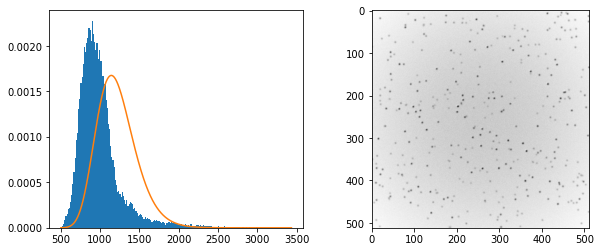

In [57]:
# redo blob detection on vignetting-corrected image, then evaluate intensities on original vignetted image again
image_vignetted_md_corrected = image_vignetted_md / (2.0 * np.pi * (vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2))** 2 *
                      (norm.cdf(yvals_upper, vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) -
                       norm.cdf(yvals_lower, vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)))[:, np.newaxis] *
                      (norm.cdf(xvals_upper, vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) -
                       norm.cdf(xvals_lower, vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)))[np.newaxis, :])

blobs_vignetted_md_corrected = blob_log(image_vignetted_md_corrected, threshold = threshold_to_use,
                                        min_sigma = 0.5 * sigma_guess,
                                        max_sigma = 2.0 * sigma_guess, num_sigma = 40)
blob_intensities_vignetted_md_corrected = []
for blob in blobs_vignetted_md_corrected:
    y, x, r = blob
    blob_intensities_vignetted_md_corrected.append(gaussian_filter(image_vignetted_md, r)[int(y), int(x)])

background_pixels_vignetted_md, image_estimated_vignetted_md, background_pixel_locations_vignetted_md = \
    pick_background_pixels_locations_after_subtracting(image_vignetted_md, blobs_vignetted_md_corrected,
                                                       blob_intensities_vignetted_md_corrected,
                                                       np.exp(vignetted_background_mle_md
                                                              .optimized_params_dict
                                                              ["background_mu"]))

data = {"num_background_pixels": len(background_pixels_vignetted_md),
        "background_pixels": background_pixels_vignetted_md,
        "pixel_locations": np.array(background_pixel_locations_vignetted_md).T,
        "max_image_dim": max(image_dims)}

vignetted_background_fit_md = vignetted_background_model.sample(data, inits = {"background_center": (image_dims[0] / 2, image_dims[1] / 2)})
vignetted_background_mle_md = vignetted_background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(background_pixels_vignetted_md, bins = "auto", density = True)
xvals = np.linspace(np.min(background_pixels_vignetted_md),
                    np.max(background_pixels_vignetted_md), 10000)
axes[0].plot(xvals, lognorm.pdf(xvals,
                                s = vignetted_background_mle_md.optimized_params_dict
                                        ["background_sigma"],
                                scale = np.exp(vignetted_background_mle_md
                                                   .optimized_params_dict
                                                   ["background_mu"])))
axes[1].imshow(image_estimated_vignetted_md, cmap = "binary")
vignetted_background_fit_md.summary()

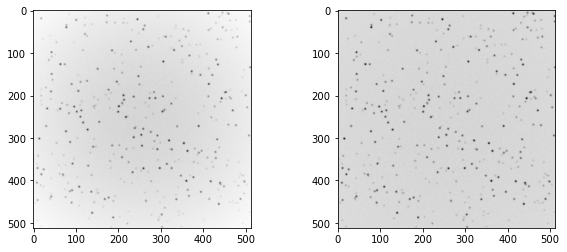

In [58]:
image_vignetted_md_corrected = image_vignetted_md / (2.0 * np.pi * (vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2))** 2 *
                      (norm.cdf(yvals_upper, vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) -
                       norm.cdf(yvals_lower, vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)))[:, np.newaxis] *
                      (norm.cdf(xvals_upper, vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) -
                       norm.cdf(xvals_lower, vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
                                vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)))[np.newaxis, :])

blobs_vignetted_md_corrected = blob_log(image_vignetted_md_corrected, threshold = threshold_to_use,
                                        min_sigma = 0.5 * sigma_guess,
                                        max_sigma = 2.0 * sigma_guess, num_sigma = 40)

blob_intensities_vignetted_md_corrected = []
closest_intensities_vignetted_md_corrected = []
for blob in blobs_vignetted_md_corrected:
    y, x, r = blob
    blob_intensities_vignetted_md_corrected.append(gaussian_filter(image_vignetted_md_corrected, r)[int(y), int(x)])
    closest_intensities_vignetted_md_corrected.append(intensities_md
                                            [np.argmin(np.square(y -
                                                       spot_centers_md[:, 0]) +
                                             np.square(x -
                                                       spot_centers_md[:, 1]))])

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].imshow(image_vignetted_md, cmap = "binary")
axes[1].imshow(image_vignetted_md_corrected, cmap = "binary", vmin = np.min(image_vignetted_md), vmax = np.max(image_vignetted_md))

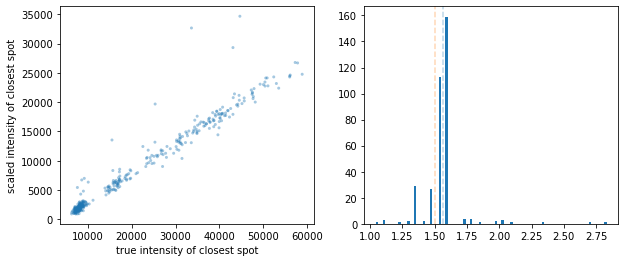

In [59]:
corrected_intensities_vignetted_md_corrected = np.empty(blobs_vignetted_md_corrected.shape[0])
blob_sigmas = np.empty(blobs_vignetted_md_corrected.shape[0])
for i, blob in enumerate(blobs_vignetted_md_corrected):
    y, x, blob_sigma = blob
    blob_sigmas[i] = blob_sigma
    corrected_intensities_vignetted_md_corrected[i] = ((blob_intensities_vignetted_md_corrected[i] -
                                    np.exp(background_mle_md
                                               .optimized_params_dict
                                               ["background_mu"])) *
                                   2.0 * np.pi * np.square(blob_sigma))

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].scatter(closest_intensities_vignetted_md_corrected, corrected_intensities_vignetted_md_corrected, alpha = 0.4,
                edgecolor = "none", marker = '.')
axes[0].set_xlabel("true intensity of closest spot")
axes[0].set_ylabel("scaled intensity of closest spot")
axes[1].hist(blob_sigmas, bins = "auto")
axes[1].axvline(np.mean(blob_sigmas), ls = "dashed", alpha = 0.3)
axes[1].axvline(spot_sigma, ls = "dashed", alpha = 0.3, color = "C1")

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


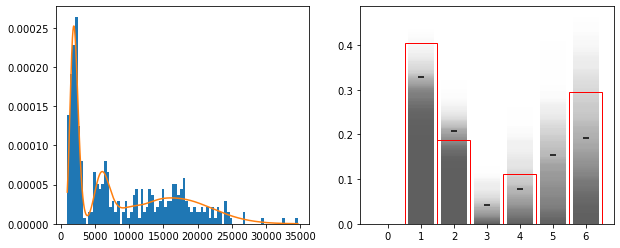

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3488.13000,0.064413,2.29506,-3492.470000,-3487.760000,-3485.120000,1269.51,3.70665,1.00240
background_level,-3189.31000,4.495920,198.00200,-3519.830000,-3188.660000,-2864.860000,1939.55,5.66301,1.00128
monomer_mu,8.34997,0.000981,0.04319,8.277650,8.351600,8.419160,1938.87,5.66101,1.00128
sigma,0.13767,0.000196,0.00930,0.123258,0.136994,0.154059,2249.42,6.56775,1.00084
p_oligomer[1],0.33000,0.000980,0.04100,0.260000,0.330000,0.400000,1789.00,5.20000,1.00000
p_oligomer[2],0.21000,0.000810,0.03700,0.150000,0.210000,0.270000,2099.00,6.10000,1.00000
p_oligomer[3],0.04100,0.000660,0.03100,0.003100,0.034000,0.100000,2273.00,6.60000,1.00000
p_oligomer[4],0.07800,0.001300,0.05900,0.005800,0.066000,0.190000,1957.00,5.70000,1.00000
p_oligomer[5],0.15000,0.001600,0.08300,0.019000,0.150000,0.290000,2665.00,7.80000,1.00000


In [60]:
data = {"num_spots": corrected_intensities_vignetted_md_corrected.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": corrected_intensities_vignetted_md_corrected - np.min(corrected_intensities_vignetted_md_corrected)}
combined_md_model_fit_vignetted_md_corrected = combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(corrected_intensities_vignetted_md_corrected, bins = data["num_spots"] // 4,
             density = True)
xvals = np.linspace(np.min(corrected_intensities_vignetted_md_corrected),
                    np.max(corrected_intensities_vignetted_md_corrected), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += np.mean(combined_md_model_fit_vignetted_md_corrected.draws()[:,:,combined_md_model_fit_vignetted_md_corrected.column_names.index("p_oligomer[" + str(i + 1) + ']')]) * binom.pmf(j, i, np.mean(combined_md_model_fit_vignetted_md_corrected.draws()[:,:,combined_md_model_fit_vignetted_md_corrected.column_names.index("p_bright")])) * lognorm.pdf(xvals - np.min(corrected_intensities_vignetted_md_corrected) - np.mean(combined_md_model_fit_vignetted_md_corrected.draws()[:,:,combined_md_model_fit_vignetted_md_corrected.column_names.index("background_level")]), s = np.mean(combined_md_model_fit_vignetted_md_corrected.draws()[:,:,combined_md_model_fit_vignetted_md_corrected.column_names.index("sigma")]), scale = (j + 1) * np.exp(np.mean(combined_md_model_fit_vignetted_md_corrected.draws()[:,:,combined_md_model_fit_vignetted_md_corrected.column_names.index("monomer_mu")])))
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_vignetted_md_corrected.draws().reshape(-1, combined_md_model_fit_vignetted_md_corrected.draws().shape[-1])[::25,:]:
    heights = [draw[combined_md_model_fit_vignetted_md_corrected.column_names.index("p_oligomer[" + str(i + 1) + ']')] for i in range(data["highest_oligomer"])]
    axes[1].bar(xvals, heights, color = "black", alpha = 0.003)
axes[1].scatter(xvals, np.mean(combined_md_model_fit_vignetted_md_corrected.draws().reshape(-1, combined_md_model_fit_vignetted_md_corrected.draws().shape[-1])[:,combined_md_model_fit_vignetted_md_corrected.column_names.index("p_oligomer[1]"):combined_md_model_fit_vignetted_md_corrected.column_names.index("p_oligomer[" + str(data["highest_oligomer"]) + ']') + 1], axis = 0), color = "black", marker = '_')
axes[1].hist(num_fluorophores, bins = np.arange(np.max(oligomeric_states) + 2) - 0.5, color = (0,0,0,0), edgecolor = "red", density = True)
plt.show()

combined_md_model_fit_vignetted_md_corrected.summary()